In [1]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Linear Regression & XGBoost & Random Forest
# =====================================================

In [2]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet

In [ ]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [4]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [5]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [6]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# -------------------------------------------------
# 5. OPTUNA: TUNE XGBOOST GPU
# -------------------------------------------------
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"        : trial.suggest_int("max_depth", 4, 18),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma"            : trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 20),
        # --- BẬT GPU ---
        "tree_method"      : "gpu_hist",
        "predictor"        : "gpu_predictor",
        "gpu_id"           : 0,
        "random_state"     : 42,
    }

    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])

    # cross‑val 5 fold, tối thiểu RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-12 06:05:18,468] A new study created in memory with name: no-name-4c716853-60a5-4557-aa50-9408f2daebe4


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:20] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:20] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:20] WARNING: /workspace/src/common

[I 2025-05-12 06:05:33,124] Trial 0 finished with value: 0.3222194809076478 and parameters: {'n_estimators': 658, 'max_depth': 6, 'learning_rate': 0.016063704916499697, 'subsample': 0.7729711095488853, 'colsample_bytree': 0.6477525326647238, 'gamma': 1.295191376431688, 'reg_alpha': 3.2566197001264987, 'reg_lambda': 5.955522352240826, 'min_child_weight': 10.846721193268447}. Best is trial 0 with value: 0.3222194809076478.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:

[I 2025-05-12 06:05:56,504] Trial 1 finished with value: 0.4210827365754334 and parameters: {'n_estimators': 488, 'max_depth': 16, 'learning_rate': 0.04713469445553657, 'subsample': 0.6125010980575137, 'colsample_bytree': 0.7518410884793036, 'gamma': 2.2767650896527685, 'reg_alpha': 9.419927276180944, 'reg_lambda': 0.18759644149988008, 'min_child_weight': 13.412774546514388}. Best is trial 0 with value: 0.3222194809076478.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:05:

[I 2025-05-12 06:06:02,462] Trial 2 finished with value: 0.32102556821376427 and parameters: {'n_estimators': 303, 'max_depth': 6, 'learning_rate': 0.1092636659304717, 'subsample': 0.9183918492113126, 'colsample_bytree': 0.8499958899616868, 'gamma': 0.8603156776777232, 'reg_alpha': 0.10713244348502389, 'reg_lambda': 0.5663149360081414, 'min_child_weight': 7.004110032492054}. Best is trial 2 with value: 0.32102556821376427.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:

[I 2025-05-12 06:06:16,260] Trial 3 finished with value: 0.30868931249038845 and parameters: {'n_estimators': 568, 'max_depth': 8, 'learning_rate': 0.023841938312743553, 'subsample': 0.6546667726922231, 'colsample_bytree': 0.7177469729308134, 'gamma': 3.7927410861137227, 'reg_alpha': 6.003964002342286, 'reg_lambda': 0.14891409554935484, 'min_child_weight': 4.358204121529875}. Best is trial 3 with value: 0.30868931249038845.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:

[I 2025-05-12 06:06:47,683] Trial 4 finished with value: 0.3697707602529916 and parameters: {'n_estimators': 660, 'max_depth': 14, 'learning_rate': 0.01354360853802217, 'subsample': 0.963130356288405, 'colsample_bytree': 0.7943608500976053, 'gamma': 2.964450027071835, 'reg_alpha': 2.3474193219177977, 'reg_lambda': 0.6484225132845055, 'min_child_weight': 18.019512020217064}. Best is trial 3 with value: 0.30868931249038845.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:06:

[I 2025-05-12 06:07:01,162] Trial 5 finished with value: 0.39658331996042456 and parameters: {'n_estimators': 948, 'max_depth': 4, 'learning_rate': 0.28744232511560325, 'subsample': 0.7626418109974188, 'colsample_bytree': 0.9830556186521869, 'gamma': 1.7341892199758224, 'reg_alpha': 4.222004840307202, 'reg_lambda': 0.14124759542149698, 'min_child_weight': 18.62876099078519}. Best is trial 3 with value: 0.30868931249038845.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:

[I 2025-05-12 06:07:35,349] Trial 6 finished with value: 0.2994585617704268 and parameters: {'n_estimators': 856, 'max_depth': 18, 'learning_rate': 0.061177929077730064, 'subsample': 0.7306415555718125, 'colsample_bytree': 0.8900608929242748, 'gamma': 4.751725336703524, 'reg_alpha': 0.184671968229936, 'reg_lambda': 2.6460956484403786, 'min_child_weight': 2.351403214797138}. Best is trial 6 with value: 0.2994585617704268.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:

[I 2025-05-12 06:07:59,525] Trial 7 finished with value: 0.38144812672347045 and parameters: {'n_estimators': 1202, 'max_depth': 7, 'learning_rate': 0.2773163679042225, 'subsample': 0.6862749725854609, 'colsample_bytree': 0.8162927763669907, 'gamma': 1.764034734259547, 'reg_alpha': 0.14788079662481757, 'reg_lambda': 1.6384738939097958, 'min_child_weight': 5.259102698042622}. Best is trial 6 with value: 0.2994585617704268.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:07:

[I 2025-05-12 06:08:27,436] Trial 8 finished with value: 0.4216504653348411 and parameters: {'n_estimators': 1133, 'max_depth': 10, 'learning_rate': 0.2169496518231184, 'subsample': 0.8255785481913545, 'colsample_bytree': 0.6676566689879718, 'gamma': 2.041485893159214, 'reg_alpha': 1.8565718072762298, 'reg_lambda': 1.600069947131865, 'min_child_weight': 8.971726795810454}. Best is trial 6 with value: 0.2994585617704268.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:

[I 2025-05-12 06:08:44,638] Trial 9 finished with value: 0.2897952304427055 and parameters: {'n_estimators': 369, 'max_depth': 15, 'learning_rate': 0.08550308172679272, 'subsample': 0.67135132178619, 'colsample_bytree': 0.9451274729178367, 'gamma': 4.610501617641377, 'reg_alpha': 0.8471271689810607, 'reg_lambda': 4.125957496591893, 'min_child_weight': 2.9043632566681974}. Best is trial 9 with value: 0.2897952304427055.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:08:

[I 2025-05-12 06:09:37,092] Trial 10 finished with value: 0.26385225151645925 and parameters: {'n_estimators': 1450, 'max_depth': 13, 'learning_rate': 0.09984690870570703, 'subsample': 0.8670142535455247, 'colsample_bytree': 0.999280297975336, 'gamma': 0.04557693579682631, 'reg_alpha': 0.6222765840899177, 'reg_lambda': 9.671027237715236, 'min_child_weight': 1.2146700747904644}. Best is trial 10 with value: 0.26385225151645925.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:09:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:09:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:09:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:09:

[I 2025-05-12 06:10:34,362] Trial 11 finished with value: 0.2634631041114791 and parameters: {'n_estimators': 1452, 'max_depth': 13, 'learning_rate': 0.10257084602214314, 'subsample': 0.874632635213165, 'colsample_bytree': 0.9988266720517223, 'gamma': 0.017932570862453118, 'reg_alpha': 0.5485191145658176, 'reg_lambda': 8.85257779098294, 'min_child_weight': 1.117949031588679}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:10:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:10:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:10:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:10:

[I 2025-05-12 06:11:10,500] Trial 12 finished with value: 0.27587722174262247 and parameters: {'n_estimators': 1500, 'max_depth': 12, 'learning_rate': 0.1351501211484088, 'subsample': 0.8682540395767312, 'colsample_bytree': 0.9916191705642919, 'gamma': 0.2240693451540492, 'reg_alpha': 0.5004881865904468, 'reg_lambda': 8.309985816942143, 'min_child_weight': 2.171122563522509}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:11:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:11:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:11:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:11:

[I 2025-05-12 06:12:17,664] Trial 13 finished with value: 0.26991420970706437 and parameters: {'n_estimators': 1489, 'max_depth': 12, 'learning_rate': 0.037712936639634036, 'subsample': 0.8685381768196287, 'colsample_bytree': 0.9040370937057001, 'gamma': 0.06700718402826587, 'reg_alpha': 0.4090212074889893, 'reg_lambda': 9.662945527552706, 'min_child_weight': 1.3407404107376166}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:

[I 2025-05-12 06:12:48,497] Trial 14 finished with value: 0.33258283696783997 and parameters: {'n_estimators': 1301, 'max_depth': 13, 'learning_rate': 0.1501480716855377, 'subsample': 0.945623842085986, 'colsample_bytree': 0.9315375619107472, 'gamma': 0.7445261865221867, 'reg_alpha': 0.3761552347721072, 'reg_lambda': 4.0198609248434645, 'min_child_weight': 6.505613124168095}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:12:

[I 2025-05-12 06:13:25,853] Trial 15 finished with value: 0.3391202099062582 and parameters: {'n_estimators': 1333, 'max_depth': 10, 'learning_rate': 0.06832216850902305, 'subsample': 0.8827050854880958, 'colsample_bytree': 0.9857616200471457, 'gamma': 3.0549392512098876, 'reg_alpha': 0.915121087162405, 'reg_lambda': 9.874567342662777, 'min_child_weight': 13.987813613841093}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:13:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:13:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:13:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:13:

[I 2025-05-12 06:14:21,091] Trial 16 finished with value: 0.3478152360896186 and parameters: {'n_estimators': 1032, 'max_depth': 17, 'learning_rate': 0.03183482142085676, 'subsample': 0.9895764956941031, 'colsample_bytree': 0.869448529981227, 'gamma': 0.6672383375756195, 'reg_alpha': 1.274798685630561, 'reg_lambda': 3.9029469597254765, 'min_child_weight': 8.259669840633931}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:14:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:14:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:14:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:14:

[I 2025-05-12 06:15:07,363] Trial 17 finished with value: 0.3033976603034464 and parameters: {'n_estimators': 1330, 'max_depth': 10, 'learning_rate': 0.08742011453954782, 'subsample': 0.8209262770768146, 'colsample_bytree': 0.9417862142802865, 'gamma': 0.039609216222522156, 'reg_alpha': 0.29266194223317393, 'reg_lambda': 1.8594721761658575, 'min_child_weight': 4.418827254861725}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:

[I 2025-05-12 06:15:40,675] Trial 18 finished with value: 0.48032591559027243 and parameters: {'n_estimators': 817, 'max_depth': 14, 'learning_rate': 0.17537121285484666, 'subsample': 0.8982036307968627, 'colsample_bytree': 0.6086950278867767, 'gamma': 1.2572287827286643, 'reg_alpha': 0.6349870647843401, 'reg_lambda': 0.4438812423519284, 'min_child_weight': 11.533100866369272}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:

[I 2025-05-12 06:16:06,976] Trial 19 finished with value: 0.264875277670897 and parameters: {'n_estimators': 1177, 'max_depth': 12, 'learning_rate': 0.10830217338315701, 'subsample': 0.8389614750427455, 'colsample_bytree': 0.9448599500137574, 'gamma': 1.250369316759566, 'reg_alpha': 0.22053225238331936, 'reg_lambda': 6.1214648989609035, 'min_child_weight': 1.3746908686699773}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:16:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:16:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:16:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:16:

[I 2025-05-12 06:17:05,213] Trial 20 finished with value: 0.3720893073180945 and parameters: {'n_estimators': 1409, 'max_depth': 15, 'learning_rate': 0.045793975194537886, 'subsample': 0.7801709443664167, 'colsample_bytree': 0.9992266525088376, 'gamma': 2.80379249347352, 'reg_alpha': 0.6454695695259992, 'reg_lambda': 1.109215152786477, 'min_child_weight': 16.11212071671504}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:

[I 2025-05-12 06:17:33,863] Trial 21 finished with value: 0.26631944885976716 and parameters: {'n_estimators': 1187, 'max_depth': 12, 'learning_rate': 0.10665371192937652, 'subsample': 0.8311579777921254, 'colsample_bytree': 0.9528269693980184, 'gamma': 0.6478275310277599, 'reg_alpha': 0.24312300621608554, 'reg_lambda': 5.766492218162284, 'min_child_weight': 1.4243029608249416}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:17:

[I 2025-05-12 06:18:10,024] Trial 22 finished with value: 0.2958219350226169 and parameters: {'n_estimators': 1104, 'max_depth': 11, 'learning_rate': 0.0736447454309606, 'subsample': 0.8380530546400157, 'colsample_bytree': 0.9120632079122089, 'gamma': 1.1932748355587675, 'reg_alpha': 0.26025881032606457, 'reg_lambda': 6.1432544382398815, 'min_child_weight': 3.6366441362501987}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:

[I 2025-05-12 06:18:46,505] Trial 23 finished with value: 0.31306106566777503 and parameters: {'n_estimators': 1249, 'max_depth': 13, 'learning_rate': 0.11027847654995228, 'subsample': 0.9230289897190193, 'colsample_bytree': 0.9558447584892418, 'gamma': 0.3683788870023039, 'reg_alpha': 1.1457989668907391, 'reg_lambda': 2.842749801523366, 'min_child_weight': 5.716988502653704}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:18:

[I 2025-05-12 06:19:07,781] Trial 24 finished with value: 0.2696440026536767 and parameters: {'n_estimators': 1407, 'max_depth': 9, 'learning_rate': 0.18553326677783902, 'subsample': 0.8616915735627335, 'colsample_bytree': 0.9668263909637502, 'gamma': 1.1422653404110097, 'reg_alpha': 0.15399052004035563, 'reg_lambda': 6.497560906955654, 'min_child_weight': 1.1127709997038946}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:

[I 2025-05-12 06:19:45,689] Trial 25 finished with value: 0.32801349444341255 and parameters: {'n_estimators': 1426, 'max_depth': 14, 'learning_rate': 0.12591234261219442, 'subsample': 0.8073883372727154, 'colsample_bytree': 0.8311456805381799, 'gamma': 0.4608717206510917, 'reg_alpha': 0.37073927725001865, 'reg_lambda': 3.174363353613432, 'min_child_weight': 3.658884947333461}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:19:

[I 2025-05-12 06:20:16,860] Trial 26 finished with value: 0.27495087467081386 and parameters: {'n_estimators': 1020, 'max_depth': 11, 'learning_rate': 0.08815840895931312, 'subsample': 0.7245394731014067, 'colsample_bytree': 0.9175200721276666, 'gamma': 1.6061218621332332, 'reg_alpha': 0.554377580626308, 'reg_lambda': 7.727616131670606, 'min_child_weight': 1.0103083862562177}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:20:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:20:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:20:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:20:

[I 2025-05-12 06:21:07,653] Trial 27 finished with value: 0.33930342311533235 and parameters: {'n_estimators': 1262, 'max_depth': 13, 'learning_rate': 0.056388814673320665, 'subsample': 0.9055068641560216, 'colsample_bytree': 0.8683258975920226, 'gamma': 0.9639412061337327, 'reg_alpha': 1.5727165992630883, 'reg_lambda': 5.05645178683278, 'min_child_weight': 7.947807307260322}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:

[I 2025-05-12 06:21:33,683] Trial 28 finished with value: 0.31403755858902005 and parameters: {'n_estimators': 1372, 'max_depth': 16, 'learning_rate': 0.2250251659812592, 'subsample': 0.8497549931350731, 'colsample_bytree': 0.9682162900386644, 'gamma': 0.03187903992210001, 'reg_alpha': 0.2158149128204308, 'reg_lambda': 0.2999674960556001, 'min_child_weight': 2.622092885460376}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:21:

[I 2025-05-12 06:22:17,168] Trial 29 finished with value: 0.4263614135266086 and parameters: {'n_estimators': 1109, 'max_depth': 15, 'learning_rate': 0.15542956185089388, 'subsample': 0.7778277705130806, 'colsample_bytree': 0.7848973592923225, 'gamma': 1.5755845070979184, 'reg_alpha': 0.7695325129212829, 'reg_lambda': 5.167852605925282, 'min_child_weight': 9.395889806290675}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:

[I 2025-05-12 06:22:55,166] Trial 30 finished with value: 0.3273181926533634 and parameters: {'n_estimators': 1487, 'max_depth': 9, 'learning_rate': 0.026540184070151768, 'subsample': 0.9498134297467309, 'colsample_bytree': 0.8861754495683426, 'gamma': 0.4817383061962074, 'reg_alpha': 0.305835056469137, 'reg_lambda': 2.355269685429711, 'min_child_weight': 10.988886857778951}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:22:

[I 2025-05-12 06:23:30,202] Trial 31 finished with value: 0.2853354819128435 and parameters: {'n_estimators': 1185, 'max_depth': 12, 'learning_rate': 0.10577673219034939, 'subsample': 0.8002546470032031, 'colsample_bytree': 0.9541281763775261, 'gamma': 0.575979559200225, 'reg_alpha': 0.10716402131500172, 'reg_lambda': 6.757284726882371, 'min_child_weight': 2.0795668217783145}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:

[I 2025-05-12 06:23:59,719] Trial 32 finished with value: 0.29337576212778427 and parameters: {'n_estimators': 775, 'max_depth': 12, 'learning_rate': 0.07707329002226385, 'subsample': 0.8432866363396279, 'colsample_bytree': 0.9711030266750738, 'gamma': 0.8904849553844054, 'reg_alpha': 0.21880106446427058, 'reg_lambda': 5.571690148666462, 'min_child_weight': 3.5200669148513137}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:23:

[I 2025-05-12 06:24:28,626] Trial 33 finished with value: 0.30776762061005314 and parameters: {'n_estimators': 985, 'max_depth': 13, 'learning_rate': 0.11373121177087692, 'subsample': 0.8893708581100591, 'colsample_bytree': 0.9270571674331014, 'gamma': 2.3465485247261713, 'reg_alpha': 0.45261033377878296, 'reg_lambda': 8.509761992171926, 'min_child_weight': 4.9774926505174815}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:24:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:24:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:24:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:24:

[I 2025-05-12 06:25:07,536] Trial 34 finished with value: 0.30135538988295707 and parameters: {'n_estimators': 1198, 'max_depth': 11, 'learning_rate': 0.09511249999853928, 'subsample': 0.7568543605364544, 'colsample_bytree': 0.7274443549210752, 'gamma': 0.3321752110067014, 'reg_alpha': 0.15351416071996668, 'reg_lambda': 4.357080092876129, 'min_child_weight': 1.0390617188082623}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:

[I 2025-05-12 06:25:36,266] Trial 35 finished with value: 0.31409016765080927 and parameters: {'n_estimators': 713, 'max_depth': 14, 'learning_rate': 0.1342484325228902, 'subsample': 0.9142438090764954, 'colsample_bytree': 0.9989439678459653, 'gamma': 0.8566953932526054, 'reg_alpha': 0.2723985841815988, 'reg_lambda': 9.90907146976186, 'min_child_weight': 6.517918975268055}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:25:

[I 2025-05-12 06:26:29,621] Trial 36 finished with value: 0.29559640431319406 and parameters: {'n_estimators': 1282, 'max_depth': 16, 'learning_rate': 0.04745269524791389, 'subsample': 0.799504091500221, 'colsample_bytree': 0.9415771700507347, 'gamma': 3.532397888559484, 'reg_alpha': 0.11120236204105718, 'reg_lambda': 6.906313525751466, 'min_child_weight': 3.4388047681816385}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:

[I 2025-05-12 06:26:44,667] Trial 37 finished with value: 0.2793526978387595 and parameters: {'n_estimators': 1065, 'max_depth': 4, 'learning_rate': 0.06749694268282291, 'subsample': 0.8196488480522515, 'colsample_bytree': 0.9723579347199068, 'gamma': 1.3719683507230074, 'reg_alpha': 0.3357237309969966, 'reg_lambda': 0.8202728571273715, 'min_child_weight': 1.932903987861947}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:26:

[I 2025-05-12 06:27:19,487] Trial 38 finished with value: 0.30828706665066774 and parameters: {'n_estimators': 911, 'max_depth': 12, 'learning_rate': 0.019310448037497038, 'subsample': 0.8784917531986483, 'colsample_bytree': 0.7604675678398333, 'gamma': 1.9944599613923653, 'reg_alpha': 3.3147428342214624, 'reg_lambda': 3.4406444962939036, 'min_child_weight': 4.4778293820733595}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:

[I 2025-05-12 06:27:36,284] Trial 39 finished with value: 0.34328110777456733 and parameters: {'n_estimators': 557, 'max_depth': 9, 'learning_rate': 0.1890693433063773, 'subsample': 0.9349050248414836, 'colsample_bytree': 0.8448800035157717, 'gamma': 0.2883439234064928, 'reg_alpha': 9.972836094777394, 'reg_lambda': 0.10279953283818394, 'min_child_weight': 5.843243900031236}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:

[I 2025-05-12 06:28:19,326] Trial 40 finished with value: 0.3109041027554412 and parameters: {'n_estimators': 1375, 'max_depth': 11, 'learning_rate': 0.10028396035491306, 'subsample': 0.6353405457483263, 'colsample_bytree': 0.8868706625273081, 'gamma': 0.6266044162220846, 'reg_alpha': 0.19536255541412592, 'reg_lambda': 5.188586794649985, 'min_child_weight': 2.992896136632271}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:

[I 2025-05-12 06:28:39,814] Trial 41 finished with value: 0.27615008634389426 and parameters: {'n_estimators': 1397, 'max_depth': 8, 'learning_rate': 0.23679772451093348, 'subsample': 0.8472766005413475, 'colsample_bytree': 0.9651443975138995, 'gamma': 1.048302410125958, 'reg_alpha': 0.14528452604259842, 'reg_lambda': 6.908078492223789, 'min_child_weight': 1.6509200883418704}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:28:

[I 2025-05-12 06:29:01,038] Trial 42 finished with value: 0.2867215241731999 and parameters: {'n_estimators': 1434, 'max_depth': 6, 'learning_rate': 0.1789566491144861, 'subsample': 0.8655741952608098, 'colsample_bytree': 0.9784764437183697, 'gamma': 1.3610793940927632, 'reg_alpha': 0.1492005471983259, 'reg_lambda': 2.1799548271428075, 'min_child_weight': 1.0392566449759064}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:

[I 2025-05-12 06:29:23,955] Trial 43 finished with value: 0.27638388990198803 and parameters: {'n_estimators': 1229, 'max_depth': 9, 'learning_rate': 0.15695273214451047, 'subsample': 0.8570163286153734, 'colsample_bytree': 0.9459784627999434, 'gamma': 1.9861607903445904, 'reg_alpha': 0.22901222862264106, 'reg_lambda': 7.864620797825387, 'min_child_weight': 2.4037240641167688}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:

[I 2025-05-12 06:29:54,460] Trial 44 finished with value: 0.31334638470141957 and parameters: {'n_estimators': 1153, 'max_depth': 10, 'learning_rate': 0.12499086533932374, 'subsample': 0.8324812196011443, 'colsample_bytree': 0.9048574984477554, 'gamma': 1.116225951877195, 'reg_alpha': 6.6323538605540335, 'reg_lambda': 4.753557987376962, 'min_child_weight': 4.207554222261562}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:

[I 2025-05-12 06:30:28,567] Trial 45 finished with value: 0.2920879650179275 and parameters: {'n_estimators': 1453, 'max_depth': 8, 'learning_rate': 0.2752407380437925, 'subsample': 0.8858964435806768, 'colsample_bytree': 0.9988755791496148, 'gamma': 0.011421984641117877, 'reg_alpha': 0.18132260873657705, 'reg_lambda': 6.180815953345256, 'min_child_weight': 2.684250487404581}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:

[I 2025-05-12 06:30:49,205] Trial 46 finished with value: 0.2666595332933638 and parameters: {'n_estimators': 1341, 'max_depth': 13, 'learning_rate': 0.1899538932590838, 'subsample': 0.9717011295698748, 'colsample_bytree': 0.9318675053091812, 'gamma': 0.8151005929349939, 'reg_alpha': 0.12583953954117624, 'reg_lambda': 8.172411812007079, 'min_child_weight': 1.711659948428489}. Best is trial 11 with value: 0.2634631041114791.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:30:

[I 2025-05-12 06:31:44,152] Trial 47 finished with value: 0.2625325919417089 and parameters: {'n_estimators': 1306, 'max_depth': 13, 'learning_rate': 0.010051568685163687, 'subsample': 0.7494836208622824, 'colsample_bytree': 0.9272789641835244, 'gamma': 4.3335235409343, 'reg_alpha': 0.12376726834371234, 'reg_lambda': 8.533344536620685, 'min_child_weight': 2.0047525057995492}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:31:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:31:

[I 2025-05-12 06:32:36,934] Trial 48 finished with value: 0.3168499204984713 and parameters: {'n_estimators': 1302, 'max_depth': 14, 'learning_rate': 0.010316104534555922, 'subsample': 0.749413855173131, 'colsample_bytree': 0.9840597805316905, 'gamma': 4.947769402717127, 'reg_alpha': 0.7199618457774393, 'reg_lambda': 3.5262380919494807, 'min_child_weight': 13.690754037756005}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:32:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:32:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:32:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:32:

[I 2025-05-12 06:33:19,534] Trial 49 finished with value: 0.3459435439485687 and parameters: {'n_estimators': 1179, 'max_depth': 12, 'learning_rate': 0.06230575567104915, 'subsample': 0.7036210059754346, 'colsample_bytree': 0.683065564078162, 'gamma': 4.255633715997073, 'reg_alpha': 0.5043216673143508, 'reg_lambda': 9.89018939469755, 'min_child_weight': 3.0119519362336273}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:33:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:33:

[I 2025-05-12 06:34:19,983] Trial 50 finished with value: 0.28419175746655173 and parameters: {'n_estimators': 1343, 'max_depth': 15, 'learning_rate': 0.017714265282378516, 'subsample': 0.7891437158918315, 'colsample_bytree': 0.9548121514797041, 'gamma': 3.5006718229949794, 'reg_alpha': 0.42334666915836916, 'reg_lambda': 7.990347971529826, 'min_child_weight': 4.352359193943085}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:

[I 2025-05-12 06:34:46,091] Trial 51 finished with value: 0.27106059756121653 and parameters: {'n_estimators': 1303, 'max_depth': 13, 'learning_rate': 0.07998652509354323, 'subsample': 0.9968552784406077, 'colsample_bytree': 0.9227584519348029, 'gamma': 4.2879422670086695, 'reg_alpha': 0.12227351792566067, 'reg_lambda': 8.496110982895758, 'min_child_weight': 2.2304634971434516}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:34:

[I 2025-05-12 06:35:46,091] Trial 52 finished with value: 0.29089167513935815 and parameters: {'n_estimators': 1342, 'max_depth': 13, 'learning_rate': 0.03971231489196219, 'subsample': 0.7349349869996069, 'colsample_bytree': 0.8940054965415637, 'gamma': 0.19141689974881593, 'reg_alpha': 0.13141590568665346, 'reg_lambda': 5.701713389180972, 'min_child_weight': 2.0606113809836515}. Best is trial 47 with value: 0.2625325919417089.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:35:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:35:

[I 2025-05-12 06:36:46,227] Trial 53 finished with value: 0.2500756962068585 and parameters: {'n_estimators': 1461, 'max_depth': 12, 'learning_rate': 0.012558204683480475, 'subsample': 0.8151540257649634, 'colsample_bytree': 0.9330360566989016, 'gamma': 0.7638925731024271, 'reg_alpha': 0.17681003288820651, 'reg_lambda': 4.416432438572594, 'min_child_weight': 1.6165520216608527}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:36:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:36:

[I 2025-05-12 06:37:38,048] Trial 54 finished with value: 0.3403795578423544 and parameters: {'n_estimators': 1470, 'max_depth': 12, 'learning_rate': 0.011490744534804446, 'subsample': 0.8158333349157645, 'colsample_bytree': 0.8640536181403485, 'gamma': 2.727001158330592, 'reg_alpha': 0.25748042555930317, 'reg_lambda': 4.272480048505123, 'min_child_weight': 12.526937240909852}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:37:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:37:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:37:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:37:

[I 2025-05-12 06:38:55,474] Trial 55 finished with value: 0.2539737699684493 and parameters: {'n_estimators': 1445, 'max_depth': 14, 'learning_rate': 0.013319233458588202, 'subsample': 0.7693858670379276, 'colsample_bytree': 0.9397023867171731, 'gamma': 0.2121127041320887, 'reg_alpha': 0.1959203932143968, 'reg_lambda': 2.7405988815203277, 'min_child_weight': 1.6744200096074626}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:38:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:38:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:38:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:38:

[I 2025-05-12 06:40:01,473] Trial 56 finished with value: 0.3572161726618347 and parameters: {'n_estimators': 1460, 'max_depth': 16, 'learning_rate': 0.02373996590400357, 'subsample': 0.7690989332518849, 'colsample_bytree': 0.936393736569496, 'gamma': 0.1409677397642772, 'reg_alpha': 0.18171952924276985, 'reg_lambda': 2.86959445418921, 'min_child_weight': 14.992922186702097}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:

[I 2025-05-12 06:40:54,979] Trial 57 finished with value: 0.33755101321260467 and parameters: {'n_estimators': 1387, 'max_depth': 14, 'learning_rate': 0.014148623637736895, 'subsample': 0.7011025628678003, 'colsample_bytree': 0.9842161657047094, 'gamma': 0.32963125456492504, 'reg_alpha': 1.0452864371193227, 'reg_lambda': 3.696851042351941, 'min_child_weight': 19.530872194794817}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:40:

[I 2025-05-12 06:42:20,251] Trial 58 finished with value: 0.3148787526216016 and parameters: {'n_estimators': 1495, 'max_depth': 17, 'learning_rate': 0.013618825195959538, 'subsample': 0.7399949174773202, 'colsample_bytree': 0.9138193809073937, 'gamma': 0.4952815318838224, 'reg_alpha': 0.3176600935805707, 'reg_lambda': 1.2897992856689755, 'min_child_weight': 5.281557476537566}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:

[I 2025-05-12 06:43:30,283] Trial 59 finished with value: 0.2726636003531076 and parameters: {'n_estimators': 1429, 'max_depth': 15, 'learning_rate': 0.011771009474926956, 'subsample': 0.7871124667925317, 'colsample_bytree': 0.958807568697434, 'gamma': 3.1299449258260386, 'reg_alpha': 0.10090646349088392, 'reg_lambda': 1.9416752133413078, 'min_child_weight': 3.096982338630254}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:

[I 2025-05-12 06:44:33,029] Trial 60 finished with value: 0.2630165707704952 and parameters: {'n_estimators': 1245, 'max_depth': 14, 'learning_rate': 0.015809034440008456, 'subsample': 0.711947209823474, 'colsample_bytree': 0.8961031613111002, 'gamma': 0.7378240922036646, 'reg_alpha': 1.540120406258378, 'reg_lambda': 4.537245552991742, 'min_child_weight': 1.594448911921653}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:

[I 2025-05-12 06:45:36,554] Trial 61 finished with value: 0.262734404621941 and parameters: {'n_estimators': 1260, 'max_depth': 14, 'learning_rate': 0.016761509242828862, 'subsample': 0.7295919051924082, 'colsample_bytree': 0.9022693762828136, 'gamma': 0.7081019286342516, 'reg_alpha': 1.5975739454818523, 'reg_lambda': 4.635531071399511, 'min_child_weight': 1.6060033715081279}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:

[I 2025-05-12 06:46:42,355] Trial 62 finished with value: 0.26381489277902037 and parameters: {'n_estimators': 1238, 'max_depth': 14, 'learning_rate': 0.015623975646328881, 'subsample': 0.7178691000752838, 'colsample_bytree': 0.9010428831151829, 'gamma': 0.6718394926615057, 'reg_alpha': 2.3192646897204225, 'reg_lambda': 1.512963900619239, 'min_child_weight': 1.7089237625137899}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:

[I 2025-05-12 06:47:39,158] Trial 63 finished with value: 0.2858966226639452 and parameters: {'n_estimators': 1251, 'max_depth': 14, 'learning_rate': 0.015828600311414445, 'subsample': 0.712502954345114, 'colsample_bytree': 0.8992812567864814, 'gamma': 0.7379065726864511, 'reg_alpha': 2.37439357912699, 'reg_lambda': 2.430384058607542, 'min_child_weight': 3.6808157457116986}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:

[I 2025-05-12 06:48:50,053] Trial 64 finished with value: 0.29836226155260964 and parameters: {'n_estimators': 1301, 'max_depth': 15, 'learning_rate': 0.020130215308331315, 'subsample': 0.6834236209669722, 'colsample_bytree': 0.8504277358816364, 'gamma': 0.47472952834523685, 'reg_alpha': 2.100896304584326, 'reg_lambda': 1.6159480739087897, 'min_child_weight': 2.591330458967379}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:

[I 2025-05-12 06:49:13,765] Trial 65 finished with value: 0.25472826129957193 and parameters: {'n_estimators': 371, 'max_depth': 14, 'learning_rate': 0.015509497078146414, 'subsample': 0.6511216998966672, 'colsample_bytree': 0.8726682815278318, 'gamma': 0.9801525686647087, 'reg_alpha': 1.5061003168188842, 'reg_lambda': 3.1456625295700618, 'min_child_weight': 1.8600127669945359}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:

[I 2025-05-12 06:49:42,821] Trial 66 finished with value: 0.270634448727725 and parameters: {'n_estimators': 411, 'max_depth': 16, 'learning_rate': 0.01232726403922917, 'subsample': 0.6527772446835005, 'colsample_bytree': 0.8830413205556003, 'gamma': 0.990373132951386, 'reg_alpha': 1.4933817240946672, 'reg_lambda': 2.8905367110580213, 'min_child_weight': 3.9967361342026653}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:

[I 2025-05-12 06:50:15,170] Trial 67 finished with value: 0.26725520463425384 and parameters: {'n_estimators': 614, 'max_depth': 13, 'learning_rate': 0.01075168349840076, 'subsample': 0.6161371800137377, 'colsample_bytree': 0.8144505809596322, 'gamma': 1.5255008634633702, 'reg_alpha': 1.344219610732541, 'reg_lambda': 4.5494596524333994, 'min_child_weight': 1.7252015095817852}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:

[I 2025-05-12 06:50:40,389] Trial 68 finished with value: 0.2879535895249224 and parameters: {'n_estimators': 460, 'max_depth': 15, 'learning_rate': 0.023246834921533906, 'subsample': 0.6619702085538953, 'colsample_bytree': 0.877289594322754, 'gamma': 0.2606712888049161, 'reg_alpha': 1.6714977198040486, 'reg_lambda': 3.263020013195887, 'min_child_weight': 3.0478715151441493}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:

[I 2025-05-12 06:50:59,247] Trial 69 finished with value: 0.31535287773416887 and parameters: {'n_estimators': 301, 'max_depth': 17, 'learning_rate': 0.01277121593952898, 'subsample': 0.7468455208790858, 'colsample_bytree': 0.9144897909578218, 'gamma': 0.7871599544847392, 'reg_alpha': 2.951948439979399, 'reg_lambda': 2.0593565168900767, 'min_child_weight': 17.06773438236495}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:

[I 2025-05-12 06:52:08,065] Trial 70 finished with value: 0.2825373246404427 and parameters: {'n_estimators': 1369, 'max_depth': 14, 'learning_rate': 0.014865817882160131, 'subsample': 0.7611421946498289, 'colsample_bytree': 0.8561505439993541, 'gamma': 0.17685460342863157, 'reg_alpha': 0.8925131505284972, 'reg_lambda': 3.8972316487589813, 'min_child_weight': 2.3742607052745477}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:

[I 2025-05-12 06:53:12,958] Trial 71 finished with value: 0.2758067472020458 and parameters: {'n_estimators': 1216, 'max_depth': 14, 'learning_rate': 0.019414294078810332, 'subsample': 0.7127773472612283, 'colsample_bytree': 0.8370320769750971, 'gamma': 0.6131650666962427, 'reg_alpha': 2.0154051290373833, 'reg_lambda': 2.535959993769433, 'min_child_weight': 1.566249685023172}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:

[I 2025-05-12 06:54:08,965] Trial 72 finished with value: 0.26650311320326475 and parameters: {'n_estimators': 1117, 'max_depth': 13, 'learning_rate': 0.016344149880477395, 'subsample': 0.7259137006120392, 'colsample_bytree': 0.8755397395727036, 'gamma': 0.4582123986294028, 'reg_alpha': 2.6114429241696993, 'reg_lambda': 1.1930385960536236, 'min_child_weight': 1.7227660835903529}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:

[I 2025-05-12 06:54:33,167] Trial 73 finished with value: 0.2529165582509928 and parameters: {'n_estimators': 349, 'max_depth': 14, 'learning_rate': 0.010047341629402391, 'subsample': 0.6840980290576808, 'colsample_bytree': 0.9027551311373228, 'gamma': 0.6876469572443229, 'reg_alpha': 1.153135729528341, 'reg_lambda': 3.121325006740938, 'min_child_weight': 1.0557822710682594}. Best is trial 53 with value: 0.2500756962068585.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:

[I 2025-05-12 06:54:54,039] Trial 74 finished with value: 0.247984073363363 and parameters: {'n_estimators': 353, 'max_depth': 13, 'learning_rate': 0.010072088805482066, 'subsample': 0.6826417950189609, 'colsample_bytree': 0.926604634609518, 'gamma': 0.9436457226666841, 'reg_alpha': 1.191382999357004, 'reg_lambda': 3.211289045725426, 'min_child_weight': 1.0107413694802605}. Best is trial 74 with value: 0.247984073363363.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:

[I 2025-05-12 06:55:21,577] Trial 75 finished with value: 0.2458486934080927 and parameters: {'n_estimators': 380, 'max_depth': 15, 'learning_rate': 0.010067450574451034, 'subsample': 0.6817908785050567, 'colsample_bytree': 0.9201416533421426, 'gamma': 0.9696969491364227, 'reg_alpha': 1.1092915804309702, 'reg_lambda': 3.1008700548188184, 'min_child_weight': 1.0212267583022063}. Best is trial 75 with value: 0.2458486934080927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:

[I 2025-05-12 06:55:47,380] Trial 76 finished with value: 0.24697806878580417 and parameters: {'n_estimators': 366, 'max_depth': 15, 'learning_rate': 0.010055323910171051, 'subsample': 0.6793572571246506, 'colsample_bytree': 0.9235637107914768, 'gamma': 1.7299510170075891, 'reg_alpha': 1.173682988472475, 'reg_lambda': 3.0689761873898176, 'min_child_weight': 1.0840211847073726}. Best is trial 75 with value: 0.2458486934080927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:

[I 2025-05-12 06:56:13,849] Trial 77 finished with value: 0.24954376485837262 and parameters: {'n_estimators': 359, 'max_depth': 15, 'learning_rate': 0.010428769925200825, 'subsample': 0.6798054250229592, 'colsample_bytree': 0.9142744922621885, 'gamma': 1.7691445538298687, 'reg_alpha': 1.1995691408956985, 'reg_lambda': 3.0786087451349538, 'min_child_weight': 1.025359161339517}. Best is trial 75 with value: 0.2458486934080927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:

[I 2025-05-12 06:56:38,734] Trial 78 finished with value: 0.25426483717960635 and parameters: {'n_estimators': 349, 'max_depth': 16, 'learning_rate': 0.013019912875548394, 'subsample': 0.6810045688949163, 'colsample_bytree': 0.9225028483593644, 'gamma': 1.7626797715079399, 'reg_alpha': 1.1351310983950875, 'reg_lambda': 2.876730170886121, 'min_child_weight': 2.579258565400239}. Best is trial 75 with value: 0.2458486934080927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:

[I 2025-05-12 06:57:06,497] Trial 79 finished with value: 0.2436002476768671 and parameters: {'n_estimators': 336, 'max_depth': 18, 'learning_rate': 0.011060427032870482, 'subsample': 0.6830516414020441, 'colsample_bytree': 0.9371484064640175, 'gamma': 1.6714439633776343, 'reg_alpha': 1.09801820662461, 'reg_lambda': 2.760205704116793, 'min_child_weight': 1.0576721661353354}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:

[I 2025-05-12 06:57:44,797] Trial 80 finished with value: 0.24461288952904708 and parameters: {'n_estimators': 478, 'max_depth': 18, 'learning_rate': 0.01096630122401137, 'subsample': 0.6360497065417745, 'colsample_bytree': 0.9379865631000631, 'gamma': 1.8859572257166037, 'reg_alpha': 1.232642836788898, 'reg_lambda': 2.248085050859533, 'min_child_weight': 1.0289509157251264}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:

[I 2025-05-12 06:58:22,907] Trial 81 finished with value: 0.2459501624745366 and parameters: {'n_estimators': 470, 'max_depth': 18, 'learning_rate': 0.010870091990701962, 'subsample': 0.6387240232245059, 'colsample_bytree': 0.9387720155078638, 'gamma': 2.169219949646628, 'reg_alpha': 1.230301224620278, 'reg_lambda': 1.8644076616325775, 'min_child_weight': 1.0423532067324104}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:

[I 2025-05-12 06:59:01,143] Trial 82 finished with value: 0.2475844560801505 and parameters: {'n_estimators': 488, 'max_depth': 18, 'learning_rate': 0.011346520612927275, 'subsample': 0.6006291494935393, 'colsample_bytree': 0.9467396160259498, 'gamma': 2.1851528890821417, 'reg_alpha': 1.247980279066648, 'reg_lambda': 1.810468297194194, 'min_child_weight': 1.036129496405074}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:

[I 2025-05-12 06:59:40,771] Trial 83 finished with value: 0.24840210943081886 and parameters: {'n_estimators': 497, 'max_depth': 18, 'learning_rate': 0.011350221063135968, 'subsample': 0.6113735594785342, 'colsample_bytree': 0.95129656853245, 'gamma': 2.1595828596709654, 'reg_alpha': 1.003978962441349, 'reg_lambda': 1.7578458895115727, 'min_child_weight': 1.0463181321627029}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:

[I 2025-05-12 07:00:20,689] Trial 84 finished with value: 0.24764409456611505 and parameters: {'n_estimators': 507, 'max_depth': 18, 'learning_rate': 0.011496553332724774, 'subsample': 0.601528102291287, 'colsample_bytree': 0.9464355536968734, 'gamma': 2.1743976215321417, 'reg_alpha': 0.9625935741063165, 'reg_lambda': 1.7879871249481003, 'min_child_weight': 1.023405544317221}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:

[I 2025-05-12 07:00:56,797] Trial 85 finished with value: 0.26492490234348554 and parameters: {'n_estimators': 492, 'max_depth': 18, 'learning_rate': 0.011205777938324474, 'subsample': 0.6097831371548845, 'colsample_bytree': 0.9498570805335013, 'gamma': 2.14696588860103, 'reg_alpha': 0.8092735810260525, 'reg_lambda': 1.410407007871407, 'min_child_weight': 3.337492851812024}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:

[I 2025-05-12 07:01:33,095] Trial 86 finished with value: 0.2598363970640921 and parameters: {'n_estimators': 486, 'max_depth': 18, 'learning_rate': 0.011650088719306532, 'subsample': 0.6242266678438598, 'colsample_bytree': 0.9620959997669483, 'gamma': 2.4513523694272052, 'reg_alpha': 1.0002141669488007, 'reg_lambda': 1.043612865013286, 'min_child_weight': 2.2990367854504736}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:

[I 2025-05-12 07:02:04,588] Trial 87 finished with value: 0.31159328398964525 and parameters: {'n_estimators': 549, 'max_depth': 18, 'learning_rate': 0.014256526834828757, 'subsample': 0.6372033502320652, 'colsample_bytree': 0.9716693038105167, 'gamma': 2.181485828360971, 'reg_alpha': 1.3127129033159686, 'reg_lambda': 1.7643257396099479, 'min_child_weight': 10.012672397904275}. Best is trial 79 with value: 0.2436002476768671.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:

[I 2025-05-12 07:02:36,130] Trial 88 finished with value: 0.2434601639120658 and parameters: {'n_estimators': 423, 'max_depth': 17, 'learning_rate': 0.011021385495287146, 'subsample': 0.6008734916260018, 'colsample_bytree': 0.9448222222784102, 'gamma': 2.571760270550245, 'reg_alpha': 0.9555936785155825, 'reg_lambda': 2.274887296002321, 'min_child_weight': 1.043349664397794}. Best is trial 88 with value: 0.2434601639120658.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:

[I 2025-05-12 07:03:06,293] Trial 89 finished with value: 0.25551752000824185 and parameters: {'n_estimators': 407, 'max_depth': 17, 'learning_rate': 0.012001334474728505, 'subsample': 0.6386545090290782, 'colsample_bytree': 0.9399866287328219, 'gamma': 1.8706914681917983, 'reg_alpha': 0.7082578458195204, 'reg_lambda': 2.226817757487849, 'min_child_weight': 2.6687589531066305}. Best is trial 88 with value: 0.2434601639120658.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:

[I 2025-05-12 07:03:41,030] Trial 90 finished with value: 0.26317166434962164 and parameters: {'n_estimators': 438, 'max_depth': 17, 'learning_rate': 0.011078728767798137, 'subsample': 0.6255630608804027, 'colsample_bytree': 0.9257512096160206, 'gamma': 2.633465192998588, 'reg_alpha': 0.8839929702157874, 'reg_lambda': 0.9285652443860664, 'min_child_weight': 2.104105156518315}. Best is trial 88 with value: 0.2434601639120658.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:

[I 2025-05-12 07:04:23,777] Trial 91 finished with value: 0.24542731315730829 and parameters: {'n_estimators': 529, 'max_depth': 18, 'learning_rate': 0.011057880215564518, 'subsample': 0.6664477843837203, 'colsample_bytree': 0.9503761594833513, 'gamma': 2.3087381076530322, 'reg_alpha': 0.9906927828211725, 'reg_lambda': 1.8489970852452877, 'min_child_weight': 1.3006840466764782}. Best is trial 88 with value: 0.2434601639120658.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:

[I 2025-05-12 07:05:02,773] Trial 92 finished with value: 0.2419856615924278 and parameters: {'n_estimators': 536, 'max_depth': 18, 'learning_rate': 0.0100930982622401, 'subsample': 0.6001255300470625, 'colsample_bytree': 0.9764952192119356, 'gamma': 2.327784817336968, 'reg_alpha': 1.369020965055911, 'reg_lambda': 2.0115574934031124, 'min_child_weight': 1.257887721739478}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:

[I 2025-05-12 07:05:42,574] Trial 93 finished with value: 0.24702571657166056 and parameters: {'n_estimators': 578, 'max_depth': 18, 'learning_rate': 0.012399255037657717, 'subsample': 0.6021273695245792, 'colsample_bytree': 0.9786658190430779, 'gamma': 2.3242545407381865, 'reg_alpha': 1.7240076024196778, 'reg_lambda': 2.0829261176122973, 'min_child_weight': 1.3451345645677675}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:

[I 2025-05-12 07:06:25,233] Trial 94 finished with value: 0.24955975292496566 and parameters: {'n_estimators': 624, 'max_depth': 18, 'learning_rate': 0.013506794365070515, 'subsample': 0.6439699956559304, 'colsample_bytree': 0.9769857933689645, 'gamma': 2.3952000958779776, 'reg_alpha': 1.769672995732873, 'reg_lambda': 2.0627646612746693, 'min_child_weight': 1.3472985545353175}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:

[I 2025-05-12 07:06:58,955] Trial 95 finished with value: 0.251299403679136 and parameters: {'n_estimators': 538, 'max_depth': 17, 'learning_rate': 0.012692325170267622, 'subsample': 0.6683775495612048, 'colsample_bytree': 0.9888643706700145, 'gamma': 2.29995433828759, 'reg_alpha': 1.4052208506641082, 'reg_lambda': 2.4125414365464803, 'min_child_weight': 2.3194358101707637}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:

[I 2025-05-12 07:07:32,397] Trial 96 finished with value: 0.2975776664678563 and parameters: {'n_estimators': 579, 'max_depth': 17, 'learning_rate': 0.01083501306735063, 'subsample': 0.6005569910996272, 'colsample_bytree': 0.9644961341382775, 'gamma': 2.5751046725603253, 'reg_alpha': 1.845542815887411, 'reg_lambda': 1.4211156697666194, 'min_child_weight': 7.842330603214351}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:

[I 2025-05-12 07:07:58,523] Trial 97 finished with value: 0.2575888973134495 and parameters: {'n_estimators': 404, 'max_depth': 18, 'learning_rate': 0.017583632515232418, 'subsample': 0.6248059512327895, 'colsample_bytree': 0.9917354482618781, 'gamma': 2.878105653430594, 'reg_alpha': 1.0721908843607737, 'reg_lambda': 1.9301289940843207, 'min_child_weight': 2.902865879863485}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:

[I 2025-05-12 07:08:32,941] Trial 98 finished with value: 0.24279599498970547 and parameters: {'n_estimators': 443, 'max_depth': 18, 'learning_rate': 0.014368897503018918, 'subsample': 0.6946306335784845, 'colsample_bytree': 0.9735679106118598, 'gamma': 1.972030907735869, 'reg_alpha': 0.7778297198743535, 'reg_lambda': 2.3052610073203135, 'min_child_weight': 1.4454253279439606}. Best is trial 92 with value: 0.2419856615924278.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:

[I 2025-05-12 07:09:05,992] Trial 99 finished with value: 0.2548852446745389 and parameters: {'n_estimators': 451, 'max_depth': 17, 'learning_rate': 0.012386003383161263, 'subsample': 0.6673807829475569, 'colsample_bytree': 0.9574269238236854, 'gamma': 1.89380893089614, 'reg_alpha': 0.7565958231959184, 'reg_lambda': 2.2423590827834254, 'min_child_weight': 2.030501594994797}. Best is trial 92 with value: 0.2419856615924278.
Best RMSLE (CV): 0.2419856615924278
Best params: {'n_estimators': 536, 'max_depth': 18, 'learning_rate': 0.0100930982622401, 'subsample': 0.6001255300470625, 'colsample_bytree': 0.9764952192119356, 'gamma': 2.327784817336968, 'reg_alpha': 1.369020965055911, 'reg_lambda': 2.0115574934031124, 'min_child_weight': 1.257887721739478}


In [8]:
# -------------------------------------------------
# 6. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-12 07:09:06,418] A new study created in memory with name: no-name-1fca980e-d983-438c-920e-c596723dda05


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-12 07:11:07,869] Trial 0 finished with value: 0.2463166076401147 and parameters: {'n_estimators': 1038, 'max_depth': 13, 'max_features': 0.6347340609116561, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.2463166076401147.


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-05-12 07:13:46,467] Trial 1 finished with value: 0.22292727323484152 and parameters: {'n_estimators': 962, 'max_depth': 18, 'max_features': 0.6479959566609004, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.22292727323484152.
[I 2025-05-12 07:16:31,979] Trial 2 finished with value: 0.26541081476053285 and parameters: {'n_estimators': 1265, 'max_depth': 12, 'max_features': 0.7663473813862276, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 1 with value: 0.22292727323484152.
[I 2025-05-12 07:17:25,552] Trial 3 finished with value: 0.3466694768147902 and parameters: {'n_estimators': 492, 'max_depth': 9, 'max_features': 0.5616819006722122, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 1 with value: 0.22292727323484152.
[I 2025-05-12 07:19:38,637] Trial 4 finished with value: 0.24211773563353586 and parameters: {'n_estimators': 676, 'max_depth': 13, 'max_features':

In [9]:
# -------------------------------------------------
# 7. HUẤN LUYỆN MÔ HÌNH TỐI ƯU & SO SÁNH VỚI LINEAR REG
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 7.1 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",  RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.2 XGB Pipeline với tham số tốt nhất
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb",  XGBRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.3 Linear Regression (có scaler sẵn trong preprocess)
lr_model = Pipeline([
    ("prep", preprocess),
    ("lr",   LinearRegression())
]).fit(X_train, y_train)

# 7.4 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lr_pred  = lr_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)
evaluate("XGBoost GPU", y_test, xgb_pred, k=k_features)
evaluate("Linear Regression", y_test, lr_pred, k=k_features)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:53:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest CPU
------------------------------
RMSE : 21.289
RMSLE: 0.176
R²   : 0.8094 | Adj‑R²: 0.8083

XGBoost GPU
------------------------------
RMSE : 21.030
RMSLE: 0.203
R²   : 0.8140 | Adj‑R²: 0.8129

Linear Regression
------------------------------
RMSE : 37.237
RMSLE: 0.879
R²   : 0.4168 | Adj‑R²: 0.4135


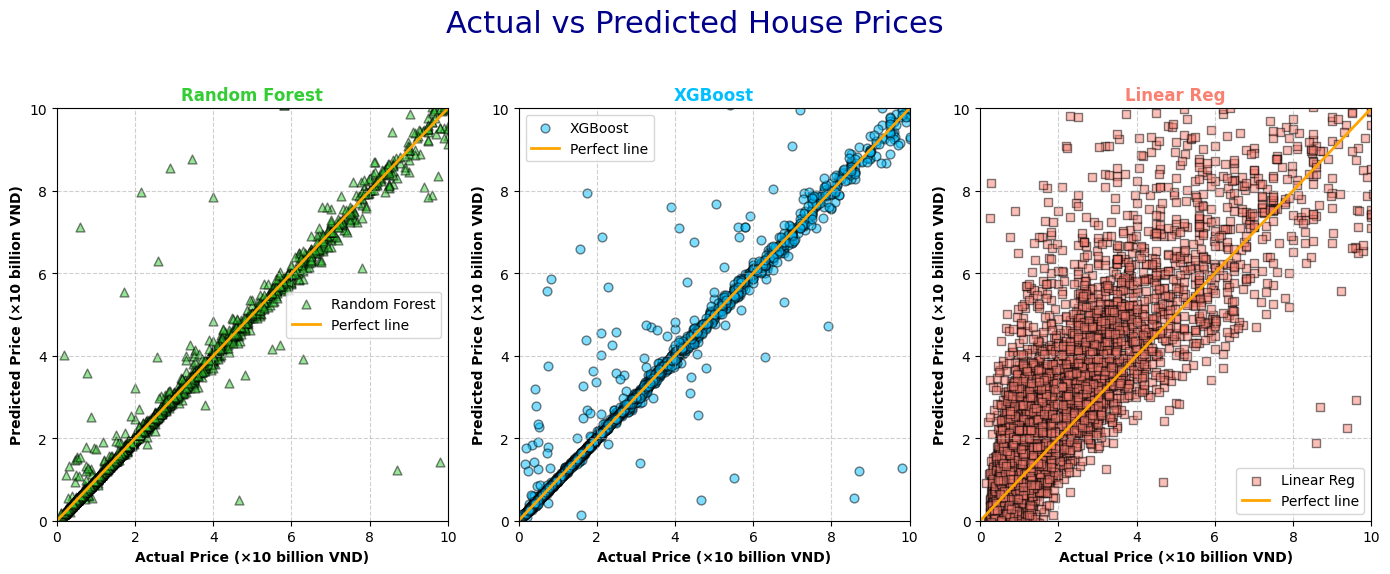

In [10]:
# -------------------------------------------------
# 8. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

models = [("Random Forest", rf_pred, "limegreen",   "^"),
          ("XGBoost", xgb_pred, "deepskyblue", "o"),
          ("Linear Reg", lr_pred, "salmon", "s")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,3,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [11]:
# -------------------------------------------------
# 9. IMPORT THƯ VIỆN
# -------------------------------------------------

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

In [12]:
# -------------------------------------------------
# 10. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",  RandomForestRegressor(**study.best_params))
])

xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**study.best_params))
])

lin_pipe = Pipeline([
        ("prep", preprocess),
        ("lr",   LinearRegression())
])

In [13]:
# -------------------------------------------------
# 10. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [14]:
# -------------------------------------------------
# 11. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('rf', rf_pipe),
                    ('xgb', xgb_pipe),
                    ('lin', lin_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [15]:
# -------------------------------------------------
# 12. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:53:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[16:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:59:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "mi

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['house_ty...
       'district_ThanhTri', 'district_ThanhXuan', 'district_ThuongTin',
       'district_UngHoa'],
      dtype='object'))])),
                                               ('lr', LinearRegression())]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [16]:
# -------------------------------------------------
# 13. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 19.271
RMSLE : 0.195
R²    : 0.8438


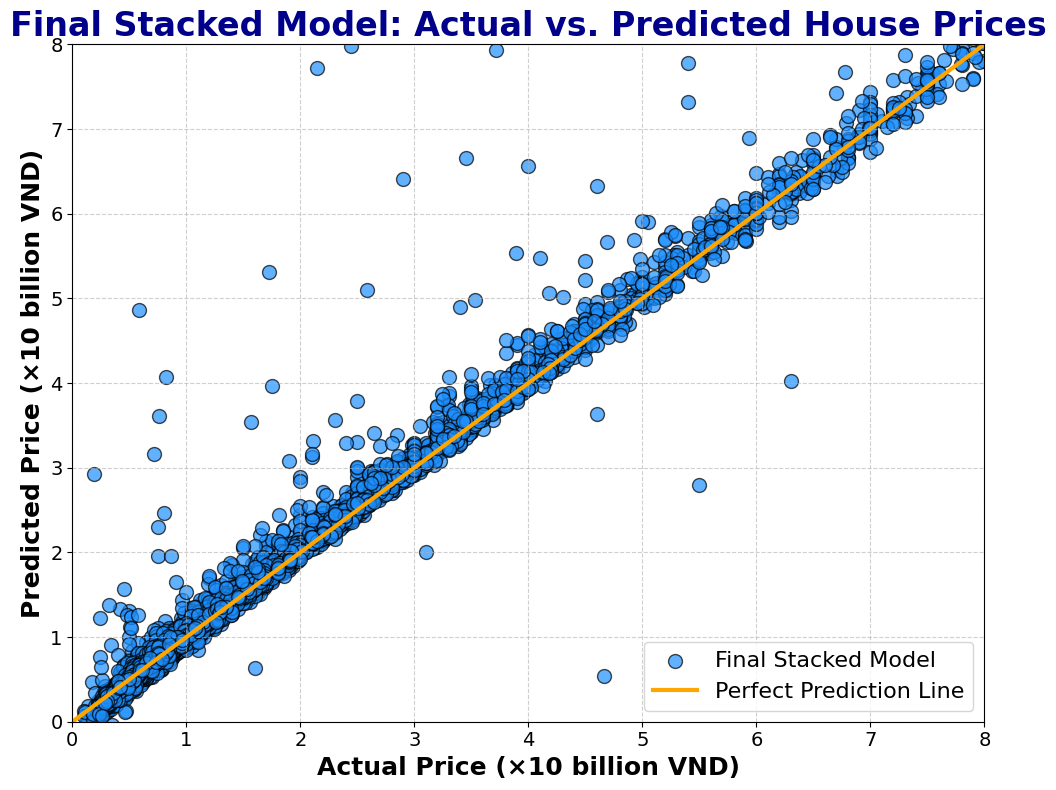

In [17]:
# -------------------------------------------------
# 14. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Đường dẫn cố định trong phiên Kaggle
MODEL_PATH = "Stack_model_Rf+Xgb+Lr.joblib"

# Lưu toàn bộ pipeline/mô hình
joblib.dump(stack, MODEL_PATH, compress=3)

print("Saved model: Stack_model_Rf+Xgb+Lr.joblib")

Saved model: Stack_model_Rf+Xgb+Lr.joblib


In [19]:
# -------------------------------------------------
# 15. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Rf+Xgb+Lr).csv", index=False)

print("Saved file: Submission_Stack_(Rf+Xgb+Lr).csv")

Saved file: Submission_Stack_(Rf+Xgb+Lr).csv
